In this notebook we present some simple illustrations of some of the fundamental mathematical ideas from the chapter.
Namely:
- Bayes optimal regressor
- Nearest neighbors and kernel regression
- Voronoi Diagram

The first demonstration is meant to illustrate how, as you decrease the window size, you. This illustrates the fundamental idea of the Bayes optimal regressor: it is optimal in a limit as you get more and more points (the consistency result we discuss in the text).

I encourage you to play around with the underlying function! Add noise, see what happens if you make it simpler or more complicated.

Window Size 2: MSE = 0.0067
Window Size 5: MSE = 0.0314
Window Size 10: MSE = 0.1415
Window Size 20: MSE = 0.4975
Window Size 50: MSE = 0.4699


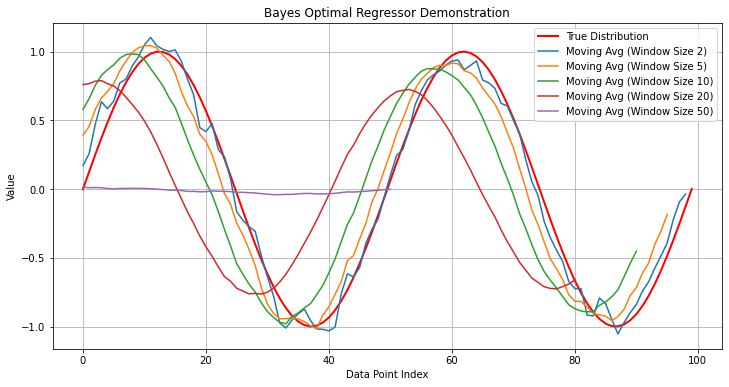

In [2]:
### BAYES OPTIMAL REGRESSOR 

import numpy as np
import matplotlib.pyplot as plt


def bayes_optimal_exp(freq):
    # Create a synthetic dataset with a known underlying distribution.
    np.random.seed(0)
    true_distribution = np.sin(np.linspace(0, freq*4 * np.pi, 100))
    data = true_distribution + np.random.normal(0, 0.1, 100)

    # Define a function to compute the moving average with a given window size.
    def moving_average(data, window_size):
        cumsum = np.cumsum(data)
        cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
        return cumsum[window_size - 1:] / window_size

    # Define a function to compute the mean squared error between the true distribution and the moving average.
    def mse(true_distribution, moving_avg):
        return np.mean((true_distribution - moving_avg) ** 2)

    # Window sizes to test
    window_sizes = [2, 5, 10, 20, 50]

    # Plot the results for different window sizes.
    plt.figure(figsize=(12, 6))
    plt.plot(true_distribution, label='True Distribution', linewidth=2, color='r')

    for window_size in window_sizes:
        moving_avg = moving_average(data, window_size)
        plt.plot(moving_avg, label=f'Moving Avg (Window Size {window_size})')

        mse_error = mse(true_distribution[window_size - 1:], moving_avg)
        print(f"Window Size {window_size}: MSE = {mse_error:.4f}")

    plt.title('Bayes Optimal Regressor Demonstration')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

bayes_optimal_exp(1)

Some observations:
- A larger window size meaans you can't cover as much of the function (more cut-off)
- The best estimate has the most trouble modeling the peaks (more trouble with this, in fact, than the overall worse estimates). 

Experiment: see what happens when we increase the frequency.

Window Size 2: MSE = 0.0348
Window Size 5: MSE = 0.3812
Window Size 10: MSE = 0.6758
Window Size 20: MSE = 0.5398
Window Size 50: MSE = 0.4782


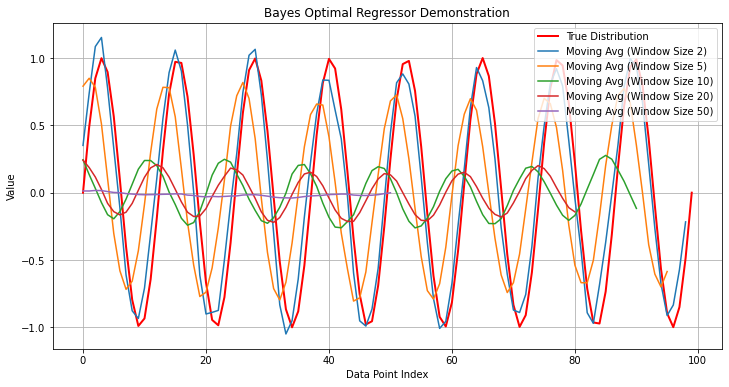

In [8]:
bayes_optimal_exp(4)

As we increase the frequency, it becomes harder to model exactly, and indeed, the estimates with larger window sizes are more and more off. Indeed, if we increase the frequency enough, we will hit a point where none of these window sizes will be able to closely approximate.

This plays on a very important idea in statistics, specifically geostatistics: you need to be sensitive to the underlying frequnecy/variance of whatever you are trying to measure/model. If you underestimate that frequency, you can be significantly off. If you overestimate it, you won't get much bang for your buck. The goal is to do just enough or a little but more than enough.

Next, we will be working with kernel regression, another basic idea we tackle in the text.

In the experiments below, we work with data from a sea surface temperature dataset.

In [74]:
########################
##### KERNEL REGRESSION
########################

from bs4 import BeautifulSoup
from IPython import embed
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

f = netCDF4.Dataset('sst.nc')

def animate(frames, saveto):
    fig, ax = plt.subplots()
    xdata, ydata = [], []
    ln, = ax.plot([], [], 'ro')
    def init():
        plt.imshow(p[0], cmap='hot', interpolation='nearest')
        return ln,

    def update(frame):
        plt.imshow(p[frame+1], cmap='hot', interpolation='nearest')
        return ln,

    ani = FuncAnimation(fig, update, frames=list(range(len(frames))), init_func=init, blit=True)
    ani.save(saveto, writer='pillow', fps=60)


We can visualize the raw data below, as an image.

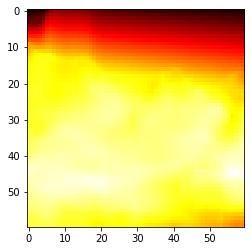

In [110]:
## the raw image

p = [f['sst'][t, 50:110, 50:110] for t in range(len(f['time']))] 
s = p[100]

plt.imshow(s, cmap='hot', interpolation='nearest')

The question that a nearest-neighbors regressor asks is effectively: how many points do I need to re-create this image? 

It turns out, you can use way less than the 100*100=10,000 pixels, and still get something that looks passable. The key is that we're taking advantage of the underlying continuity of the field that we are measuring (again, playing on that idea that we ought to understand and take advantage of the underlying variation structure in what we measure).

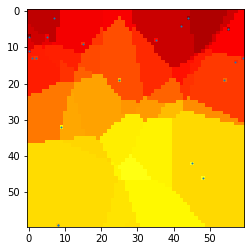

In [84]:
from scipy.spatial import distance_matrix

## nearest neighbors regression


def get_ixs(p, num_sample):
    p = np.array(p)
    p_var = np.var(p, axis=0)
    p_var /= sum(sum(p_var))


    class Ix():
        def __init__(self, i,j):
            self.i = i
            self.j = j

    p_ix = [Ix(i,j) for i in range(len(p_var)) for j in range(len(p_var))]
    np.array(p_ix).shape
    sampled_ixs = np.random.choice(np.array(p_ix).ravel(), num_sample, p=np.array(p_var).ravel())
    ixs = [(ix.i,ix.j) for ix in sampled_ixs]
    return ixs


def dist(ix1,ix2):
    return ((ix2[0]-ix1[0])**2 + (ix2[1]-ix1[1])**2)**0.5

# returns the k elements in the ixs array closest to a given point
def arg_nn(pt, k,ixs):
    dists = np.array([dist(pt, ix) for ix in ixs])
    return dists.argsort()[:k][::-1]

# really stupid 
def nn_avg(points, ixs, k, dim=len(p[0])):
    surface = np.zeros((dim,dim))
    for i in range(dim):
        for j in range(dim):
            if (i,j) in ixs:
                surface[i,j] = points[ ixs.index((i,j)) ]
            else:
                knn_ixs = arg_nn([i,j], k, ixs)
                #print(knn_ixs)
                avg = sum(points[knn_ixs])/k
                surface[i,j] = avg
    return surface

n=20
k=3

ixs = get_ixs(p,n)
field = np.array([s[ix[0],ix[1]] for ix in ixs])
s_pred = nn_avg(field,ixs,k)
plt.imshow(s_pred, cmap='hot',vmin=10, vmax=35)
plt.scatter(np.array(ixs).T[1], np.array(ixs).T[0],s=1)

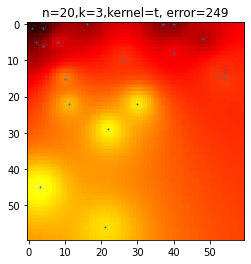

In [88]:
## nearest neighbors with a kernel

def t(x):
    return 0.005/(1+x**2)

def e(x):
    return np.exp(-x)


def kernel_avg(points, ixs, type='t', dim=len(p[0])):
    surface = np.zeros((dim,dim))
    for i in range(dim):
        for j in range(dim):
            if type=='t':
                weight =  np.array([t(dist([i,j],ix)) for ix in ixs])
            elif type=='e':
                weight =  np.array([e(dist([i,j],ix)) for ix in ixs])
            weight /= sum(weight)
            surface[i,j] = points.dot(weight)

    return surface

n=20
k=3

ixs = get_ixs(p,n)
field = np.array([s[ix[0],ix[1]] for ix in ixs])

kernel = 't'
s_pred2 = kernel_avg(field,ixs,type=kernel)
error = int(np.linalg.norm(s_pred2-s))
plt.title('n='+str(n)+',k='+str(k)+ ',kernel=' +kernel + ', error='+str(error))
plt.imshow(s_pred2, cmap='hot',vmin=10, vmax=35)
plt.scatter(np.array(ixs).T[1], np.array(ixs).T[0],s=1)

One can continue experimenting with all kinds of kernels. 
One can also consider extending this problem into the third dimension, looking at how to model not just a surface but a surface evolving over time continuously. This adds a whole other layer of complexity to the problem: understanding the correlation of space and time in these kinds of systems requires some sort of physical priors, and if you really want to get fancy, differential equations.

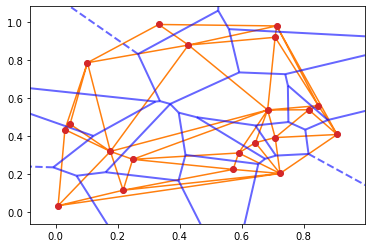

In [72]:
########################
##### VORONOI DIAGRAM
########################

from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay


# you can experiment with different initializations of the points
# for instance, if they are generated from a Gaussian
points = np.random.rand(20, 2)


vor = Voronoi(points)
fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='blue',
                      line_width=2, line_alpha=0.6, point_size=10)

tri = Delaunay(points)
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

Above, we visualize the Voronoi diagram (blue) and its dual Delaunay triangulation (orange). Re-running the code will yield different placements of the points and the triangulations. It is sort of fun to watch.

In the last few cells, we visualize these things separately.

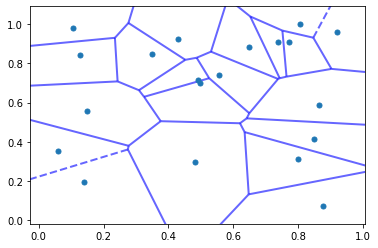

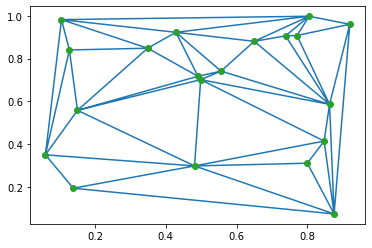

In [57]:
# here, we visualize them separately
fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='blue',
                      line_width=2, line_alpha=0.6, point_size=10)
plt.show()

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()